In [6]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re
import string
import scipy.sparse
import emoji
from emot.emo_unicode import UNICODE_EMOJI
from emosent import get_emoji_sentiment_rank
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from pprint import pprint
import math
warnings.simplefilter(action='ignore')

In [7]:
# Read in Data
RESTAURANT_LOC = '../data/restaurants_detailed.csv'
REVIEWS_LOC = '../data/reviews.csv'
restaurants = pd.read_csv(RESTAURANT_LOC, encoding='utf-8-sig')
reviews = pd.read_csv(REVIEWS_LOC, encoding='utf-8-sig')

In [8]:
restaurants_cp = restaurants.sort_values(by='restaurant_id').reset_index(drop=True).copy()
reviews_cp = reviews[reviews['restaurant_code'].isin(restaurants_cp['restaurant_code'].unique())].copy()

# Basic preprocessing
exc_rest_cols = ['categories', 'restaurant_description',
                 'restaurant_operating_hours', 'restaurant_number', 'restaurant_name',
                 'restaurant_address', 'restaurant_website', 'restaurant_photo', 'location']
exc_reviews_cols = ['account_photo', 'review_photo', 'account_level', 'account_name']

restaurants_cp['lg_ppp'] = np.log(restaurants_cp['price_per_pax'])
restaurants_exc = restaurants_cp[[x for x in restaurants_cp.columns if x not in exc_rest_cols]]
restaurants_exc['price_cat'] = pd.cut(restaurants_exc['lg_ppp'], bins=5, labels=np.arange(5))

reviews_exc = reviews_cp[[x for x in reviews_cp.columns if x not in exc_reviews_cols]]
reviews_exc[['review_title', 'review_body']] = reviews_exc[['review_title', 'review_body']].fillna('')
reviews_exc['full_review'] = reviews_exc['review_title'] + ' ' +  reviews_exc['review_body']
reviews_exc = reviews_exc.drop(columns=['review_title', 'review_body'])
reviews_exc['review_date'] = reviews_exc['review_date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y').year)
reviews_exc['scraped_date'] = reviews_exc['scraped_date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y').year)
reviews_exc['full_review'] = reviews_exc['full_review'].astype('str')
reviews_exc = reviews_exc.groupby(['account_id', 'review_date', 'scraped_date', 'restaurant_code'])['full_review']\
    .agg(lambda x: ' '.join(x)).rename('agg_review').reset_index()

27608 | INFO | Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
27608 | INFO | NumExpr defaulting to 8 threads.


### Clean Text

In [9]:
eng_stopwords = set(stopwords.words('english'))

# Remove the breakline
reviews_exc['processed_review'] = reviews_exc['agg_review'].apply(lambda x: re.sub(r'\n', ' ', x))

# Remove @s since they denote location which is already captured
reviews_exc['processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: re.sub(r'@[a-zA-Z0-9]{1,}\s+', ' ', x))

# Remove hashtags
reviews_exc['processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: re.sub(r'(#[a-zA-Z0-9]{1,})', ' ', x))

# Lower Case Words
reviews_exc['processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: x.lower())

# Remove Stop Words
reviews_exc['processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: ' '.join([e for e in x.split() if e not in eng_stopwords]))

# Remove Punctuations and Special Characters
reviews_exc['processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))))

# Remove Numbers
reviews_exc['processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: x.translate(str.maketrans(' ', ' ', string.digits)))

# Remove Extra Space
reviews_exc['processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: re.sub('\s+', ' ', x).strip())

# Remove Single Letter Words
reviews_exc['processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: ' '.join([e for e in x.split() if len(e) > 1]))

### Generate Sentiment Scores

In [13]:
print(reviews_exc.shape)

(232773, 6)


In [15]:
# Util
singlish_lexi_df = pd.read_csv('../data/singlish_dictionary_list.csv')
singlish_lexi_df['compound'] = singlish_lexi_df['positive'] + singlish_lexi_df['negative']
singlish_lexi = {e['term']: e['compound'] for e in singlish_lexi_df[['term', 'compound']].to_dict(orient='records')}

sid_obj = SentimentIntensityAnalyzer()

def get_emoji_regexp():
    # Sort emoji by length to make sure multi-character emojis are
    # matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

def emoji_sentiment(word):
    for u_emo in UNICODE_EMOJI:
        if u_emo in word:
            try:
                return get_emoji_sentiment_rank(u_emo)['sentiment_score']
            except:
                return 0
    return 0

def generate_sentiment_score(x):
    pr_arr = x['processed_review'].split()
    positive = 0
    negative = 0
    for word in pr_arr:
        emoji_check = [x for x in get_emoji_regexp().split(word) if x != '']
        for emoji_char in emoji_check:
            emoji_senti = emoji_sentiment(emoji_char)
            if emoji_senti < 0:
                negative += 1
            elif emoji_senti > 0:
                positive += 1
        sid_senti = sid_obj.polarity_scores(word)['compound']
        sing_lexi = singlish_lexi.get(word, 0)
        if sid_senti < 0 or sing_lexi < 0:
            negative += 1
        elif sid_senti > 0 or sing_lexi > 0:
            positive += 1
    sentiment_score = np.log(positive+0.5) - np.log(negative+0.5)
    if x.name % 100 == 0:
        print(x.name)
    return sentiment_score

reviews_exc['sentiment_score'] = reviews_exc.apply(lambda x: generate_sentiment_score(x), axis=1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

### Generate Temporal Features

In [16]:
reviews_exc['temporal_difference'] = reviews_exc.apply(lambda x: (x['scraped_date']- x['review_date']), axis=1)
reviews_exc['temporal_weight'] = reviews_exc['temporal_difference'].apply(lambda x: 1/(1+x**.5))
reviews_exc['temporal_weight'] = reviews_exc['temporal_weight'].apply(lambda x: x.real)

<AxesSubplot:>

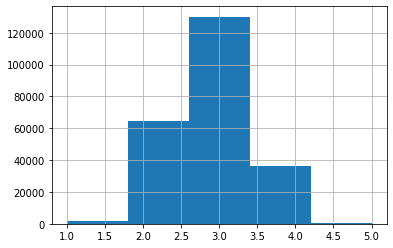

In [17]:
# IR
reviews_exc['intrinsic_rating'] = pd.cut(reviews_exc['sentiment_score'], bins=5, labels=np.arange(1,6))
reviews_exc['intrinsic_rating'] = reviews_exc['intrinsic_rating'].astype('int')
reviews_exc['intrinsic_rating'].hist(bins=5)

<AxesSubplot:>

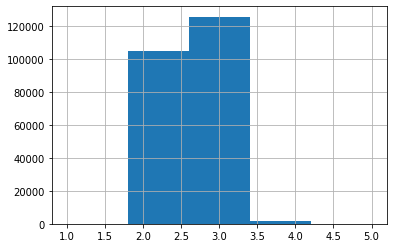

In [18]:
# TWSIR
reviews_exc['TWSIR'] = pd.cut(reviews_exc['sentiment_score'] * reviews_exc['temporal_weight'], bins=5, labels=np.arange(1,6))
reviews_exc['TWSIR'] = reviews_exc['TWSIR'].astype('int')
reviews_exc['TWSIR'].hist(bins=5)

### Generate Textual Features

In [99]:
# Generate word embeddings
STEMMER = PorterStemmer()

reviews_exc['emoji_none_processed_review'] = reviews_exc['processed_review']\
    .apply(lambda x: ''.join([e for e in get_emoji_regexp().split(x) if e != '' and e not in UNICODE_EMOJI]))
reviews_exc['emoji_none_processed_review'] = reviews_exc['emoji_none_processed_review']\
    .apply(lambda x: re.sub('\s+', ' ', x).strip())

# Stem the tokens
reviews_exc['stem_reviews'] = reviews_exc['emoji_none_processed_review'].apply(lambda x: [STEMMER.stem(word) for word in x.split()])
reviews_exc

,account_id,review_date,scraped_date,restaurant_code,agg_review,processed_review,sentiment_score,temporal_difference,temporal_weight,intrinsic_rating,TWSIR,emoji_none_processed_review,stem_reviews,sentence_embedding,account_uuid,restaurant_uuid
0,@-lihong-,2018,2021,en-sushi,Delicious And Great Food! Was recommended En S...,delicious great food recommended en sushi frie...,2.944439,3,0.366025,4,3,delicious great food recommended en sushi frie...,"[delici, great, food, recommend, en, sushi, fr...","[-0.29096097, -0.67483956, -0.9276358, 0.48409...",0,3445
1,@-lihong-,2018,2021,ramen-nagi-singapore,Good Food And Atmosphere! Had a great dinner w...,good food atmosphere great dinner friends rame...,2.564949,3,0.366025,4,3,good food atmosphere great dinner friends rame...,"[good, food, atmospher, great, dinner, friend,...","[-0.28376, -1.0442414, -0.8256175, 0.29673934,...",0,9597
2,@-lihong-,2019,2021,elixir-boutique-roasters,Delicious Food And Drinks I ordered the french...,delicious food drinks ordered french toast bru...,1.299283,2,0.414214,3,3,delicious food drinks ordered french toast bru...,"[delici, food, drink, order, french, toast, br...","[-0.050187163, -0.24867271, -0.22761059, 0.481...",0,3419
3,@0145may,2014,2021,carpenter-and-cook,Sunday Brunch Sunday Brunch trying on Passion ...,sunday brunch sunday brunch trying passion fru...,1.098612,7,0.274292,3,2,sunday brunch sunday brunch trying passion fru...,"[sunday, brunch, sunday, brunch, tri, passion,...","[0.54446703, -0.40302438, -0.09922674, -0.1589...",1,2066
4,@01winaz88,2017,2021,chir-chir-singapore,Cheese toppoki @chirchirsg Somerset 313I prefe...,cheese toppoki somerset prefer mac cheese topp...,0.000000,4,0.333333,2,2,cheese toppoki somerset prefer mac cheese topp...,"[chees, toppoki, somerset, prefer, mac, chees,...","[0.29969165, 1.0408927, 0.11143442, -0.3077048...",2,2406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232768,@zzzling,2013,2021,wild-honey-1,Sandwich Birthday treat Californian,sandwich birthday treat californian,1.098612,8,0.261204,3,2,sandwich birthday treat californian,"[sandwich, birthday, treat, californian]","[-0.800842, -1.1718298, -0.002377892, 0.370395...",14160,13133
232769,@zzzling,2014,2021,alexandra-village-food-centre,Bestest lunch for 2 #burp Bestest lunch for 2 ...,bestest lunch bestest lunch,0.000000,7,0.274292,2,2,bestest lunch bestest lunch,"[bestest, lunch, bestest, lunch]","[-0.24843045, -1.4682941, 0.24152571, 0.320344...",14160,659
232770,@zzzling,2014,2021,nectar,Nasi Goreng August special dish available for ...,nasi goreng august special dish available dinner,1.098612,7,0.274292,3,2,nasi goreng august special dish available dinner,"[nasi, goreng, august, special, dish, avail, d...","[0.30524656, -1.7989957, -0.52669394, 0.448400...",14160,8264
232771,@zzzling,2014,2021,potato-head-folk,Burgers Letdown - overpriced though taste was ...,burgers letdown overpriced though taste quite ...,1.098612,7,0.274292,3,2,burgers letdown overpriced though taste quite ...,"[burger, letdown, overpr, though, tast, quit, ...","[0.36043006, -0.24329805, -1.7504952, -0.13089...",14160,9323


In [100]:
# Word2Vec
w2v = Word2Vec(reviews_exc['stem_reviews'], vector_size=50)

27608 | INFO | collecting all words and their counts
27608 | INFO | PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
27608 | INFO | PROGRESS: at sentence #10000, processed 137274 words, keeping 10862 word types
27608 | INFO | PROGRESS: at sentence #20000, processed 309713 words, keeping 16867 word types
27608 | INFO | PROGRESS: at sentence #30000, processed 594154 words, keeping 23833 word types
27608 | INFO | PROGRESS: at sentence #40000, processed 1080568 words, keeping 32821 word types
27608 | INFO | PROGRESS: at sentence #50000, processed 1543416 words, keeping 39903 word types
27608 | INFO | PROGRESS: at sentence #60000, processed 2138059 words, keeping 46001 word types
27608 | INFO | PROGRESS: at sentence #70000, processed 2515832 words, keeping 49565 word types
27608 | INFO | PROGRESS: at sentence #80000, processed 2931599 words, keeping 54453 word types
27608 | INFO | PROGRESS: at sentence #90000, processed 3344830 words, keeping 58304 word types
27608 | INFO |

In [101]:
reviews_exc = reviews_exc[reviews_exc['stem_reviews'].str.len() > 0]

def get_sentence_embedding(x):
    word_vec = 0
    for char in x:
        if char in w2v.wv:
            word_vec += w2v.wv[char]
    return word_vec / len(x)
reviews_exc['sentence_embedding'] = reviews_exc['stem_reviews']\
    .apply(lambda x : get_sentence_embedding(x))

### Generate Interaction Matrix

In [22]:
restaurant_id = {x[1]: x[0] for x in enumerate(sorted(list(reviews_exc['restaurant_code'].unique())))}
account_uuids = {x[1]: x[0] for x in enumerate(sorted(list(reviews_exc['account_id'].unique())))}
reviews_exc['account_uuid'] = reviews_exc['account_id'].apply(lambda x: account_uuids[x])
reviews_exc['restaurant_uuid'] = reviews_exc['restaurant_code'].apply(lambda x: restaurant_id[x])
print(len(account_uuids))
print(len(restaurant_id))

14161
13849


In [23]:
# BUI
interaction_mat = reviews_exc[['account_uuid', 'restaurant_uuid']].drop_duplicates()
interaction_mat['visits'] = 1
interaction_mat = interaction_mat.pivot(index='account_uuid', columns='restaurant_uuid', values='visits').fillna(0)\
    .rename_axis(None).rename_axis(None, axis=1)
sparse_interaction_mat = scipy.sparse.csc_matrix(interaction_mat)
scipy.sparse.save_npz('../data/sparse_interaction_matrix.npz', sparse_interaction_mat)

In [24]:
# TWSIR
twsir_mat = reviews_exc[['account_uuid', 'restaurant_uuid', 'TWSIR']]
twsir_mat = twsir_mat.groupby(['account_uuid', 'restaurant_uuid'])['TWSIR'].mean().reset_index()
twsir_mat['TWSIR'] = twsir_mat['TWSIR'].apply(lambda x: math.ceil(x))
twsir_mat['TWSIR'] = twsir_mat['TWSIR'].apply(lambda x: 1 if x > 2 else 0)
twsir_mat = twsir_mat.pivot(index='account_uuid', columns='restaurant_uuid', values='TWSIR').fillna(0)\
    .rename_axis(None).rename_axis(None, axis=1)
sparse_twsir_mat = scipy.sparse.csc_matrix(twsir_mat)
scipy.sparse.save_npz('../data/sparse_twsir_matrix.npz', sparse_twsir_mat)

### Generate Data File for Training

In [102]:
reviews_exc.to_csv('../data/main.csv', index=False)

In [103]:
# Roll up data in reviews_exc by users
word_embed = reviews_exc.copy()
word_embed['sentence_embedding'] = word_embed['sentence_embedding'].apply(lambda x: np.array(x))
word_embed_grouped = word_embed.groupby(['account_uuid', 'restaurant_uuid'])['sentence_embedding'].apply(np.mean)

In [104]:
word_embed_main = word_embed_grouped.reset_index()
word_embed_main = pd.concat([word_embed_main, pd.DataFrame(word_embed_main['sentence_embedding'].apply(pd.Series))], axis=1)
word_embed_main = word_embed_main.drop(columns=['sentence_embedding'])
word_embed_main

,account_uuid,restaurant_uuid,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,0,3419,-1.042806,0.792544,1.738121,1.014905,0.887546,1.264772,-0.303580,-0.033384,...,-0.190815,0.584835,0.251871,0.081338,-1.123044,-0.727730,0.936806,0.538889,0.255586,0.512240
1,0,3445,-2.067598,-0.427022,0.742813,1.166361,1.168604,0.646715,-0.005900,-1.274771,...,-0.156103,-1.075681,-0.337393,0.871795,-0.893115,-0.738809,0.533666,1.365243,-1.222210,-0.443038
2,0,9597,-1.328657,0.319492,0.030706,0.532697,1.931614,-0.445214,0.714200,-1.624878,...,0.737685,-1.056214,-0.294933,0.572559,-1.349280,-0.735138,-1.018374,1.534576,-1.873500,-0.106362
3,1,2066,-0.529848,0.479460,2.250158,1.582183,0.503618,1.530363,-0.116237,0.662764,...,0.906213,0.026953,0.061624,-0.565182,-1.235271,-0.125687,-0.676486,-0.677777,1.648387,0.723412
4,2,1252,-0.213159,-1.378206,-0.106376,1.455348,-0.389465,0.857792,-0.074717,-0.308508,...,0.018292,-0.331469,0.820518,0.522897,-0.792903,0.879473,-0.877250,-0.977039,-0.345582,-1.259423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210399,14160,8264,-0.263424,0.366230,0.345252,0.336626,1.339305,-0.699921,0.822286,1.298009,...,-0.286337,-1.274363,0.456506,0.173752,-0.532513,0.911464,-1.796383,1.146926,-1.510642,-0.669702
210400,14160,9323,-2.827324,-0.394026,0.364946,0.379283,0.701648,-0.001136,0.017714,-1.391921,...,0.434462,-1.628705,-0.726141,0.008451,-1.426296,-0.705935,-0.659463,1.723201,-0.848973,-0.102433
210401,14160,11701,-0.677331,-1.612210,1.433130,0.458253,0.972766,1.200122,0.623438,0.537697,...,0.127110,-0.097795,0.148501,0.567743,-0.784670,-0.890144,1.681490,0.266660,-0.169767,0.428076
210402,14160,12383,2.195392,0.318269,0.772038,0.851527,1.037142,0.113183,1.038724,-1.836425,...,-0.554402,0.868878,1.482206,0.726958,-1.043405,-0.237964,1.644699,-0.422446,-0.430463,-0.927849


In [105]:
word_embed_main.to_csv('../data/word_embed.csv', index=False)

In [40]:
# Roll Up Ratings by Restaurants
senti_rest = pd.DataFrame(reviews_exc.groupby(['restaurant_uuid','restaurant_code'])['intrinsic_rating'].mean()).reset_index()
senti_rest.to_csv('../data/restaurant_sentiment.csv', index=False)

In [86]:
# Users
users = reviews_exc[['account_id', 'account_uuid']].drop_duplicates()
users.to_csv('../data/users.csv', index=False)

In [41]:
rest_output = senti_rest.merge(restaurants_exc, how='inner', on='restaurant_code').drop_duplicates(subset=['restaurant_code']).reset_index()
rest_output = rest_output[['restaurant_uuid', 'Italian', 'Malay',
       'Japanese', 'Chinese', 'Western', 'Korean', 'Thai', 'Vietnamese',
       'Mexican', 'Indian', 'Local Delights', 'Desserts', 'Healthy',
       'Cafes & Coffee', 'Halal', 'Beverages', 'Others', 'price_cat']]
rest_output.to_csv('../data/attr_aspect.csv', index=False)